In [98]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import re
from scipy.optimize import curve_fit
from scipy.optimize import minimize_scalar

In [40]:
def getPopSizeOverTimeFromFile(filename):
    
    with open(filename) as infile:
        reader = csv.reader(infile, delimiter="\t")
        nCols = len(next(reader)) #gets the no. of columns in file, i.e., features of data
        # also this skips the first line, which is all headers
        
        column_array = [[] for i in range(nCols)] #creates an empty array of length nCols to store the data
        
        
        for row in reader:
            for i in range(len(row)):
                column_array[i].append(float(row[i].strip()))
                
        return column_array
        
        
        
        
times, nAlive, nDead = getPopSizeOverTimeFromFile('Pyrithione_testing_c=10.0.txt') 
print(nAlive)

[599999.667, 591292.833, 582710.333, 574173.167, 565866.833, 557596.167, 549451.5, 541439.167, 533490.833, 525672.333, 518055.5, 510538.167, 503120.833, 495807.667, 488622.167, 481472.5, 474471.833, 467567.0, 460800.167, 454136.167, 447505.0, 441050.5, 434606.333, 428353.833, 422120.0, 415980.833, 409952.5, 403978.333, 398105.333, 392270.333, 386547.833, 380871.167, 375304.833, 369834.667, 364487.0, 359138.5, 353921.5, 348804.5, 343730.0, 338776.833, 333898.167, 329072.167, 324325.333, 319586.833, 314930.333, 310361.5, 305869.833, 301410.667, 297025.5, 292745.5, 288474.333, 284245.167, 280069.167, 275976.333, 271947.667, 267925.667, 263994.833, 260108.333, 256352.333, 252609.5, 248955.833, 245342.5, 241805.0, 238299.667, 234785.333, 231369.5, 227985.5, 224673.167, 221401.5, 218190.833, 215014.0, 211894.167, 208785.5, 205762.5, 202777.167, 199837.5, 196905.167, 194028.667, 191215.833, 188440.0, 185714.833, 183023.5, 180348.667, 177743.833, 175153.667, 172586.167, 170057.0, 167556.0, 165

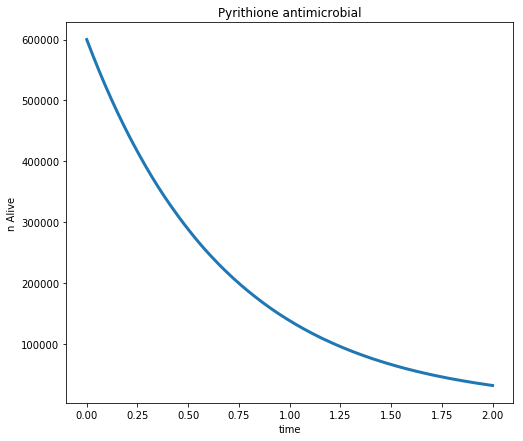

In [41]:
def plotPyrithioneTestingResults(tData, liveData, deadData):
    
    plt.figure(figsize=(8,7))
    plt.plot(tData, liveData, linewidth=3)
    plt.xlabel('time')
    plt.ylabel('n Alive')
    plt.title('Pyrithione antimicrobial')
    plt.savefig('pyrithione_testing_c=10.0.png')
    plt.show()
    
plotPyrithioneTestingResults(times, nAlive, nDead)

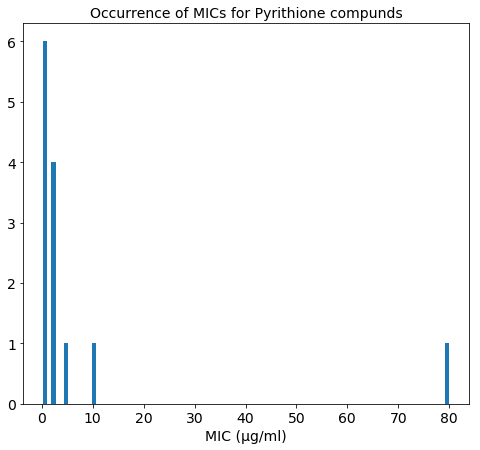

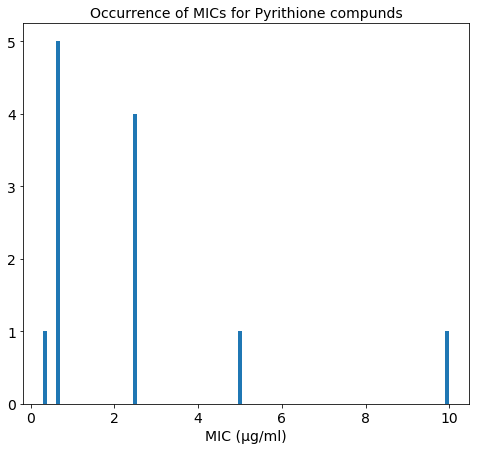

In [42]:
def histogramOfPyrithioneMIC():
    
    #gram-negative bacteria
    listOfMICs = [2.5, 2.5, 5.0, 80.0, 2.5, 10.0]
    #gram-positive bacteria
    listOfMICs2 = [0.6, 0.6, 0.6, 0.6, 0.3, 2.5, 0.6]
    #yeasts
    #listOfMICs3 = [0.15, 1.25, 0.15, 0.3, 0.2]
    
    allMICs = listOfMICs+listOfMICs2
    
    font_size = 14
    
    plt.figure(figsize=(8,7))
    plt.hist(allMICs, bins=100)
    
    plt.tick_params(labelsize=14)
    plt.title('Occurrence of MICs for Pyrithione compunds', fontsize=font_size)
    plt.xlabel('MIC (μg/ml)', fontsize=font_size)

    plt.savefig('Pyrithione-MIC-histogram.png')
    plt.show()
    

def histogramOfPyrithioneMIC_noOutlier():
    
    #gram-negative bacteria
    listOfMICs = [2.5, 2.5, 5.0, 2.5, 10.0]
    #gram-positive bacteria
    listOfMICs2 = [0.6, 0.6, 0.6, 0.6, 0.3, 2.5, 0.6]
    #yeasts
    #listOfMICs3 = [0.15, 1.25, 0.15, 0.3, 0.2]
    
    allMICs = listOfMICs+listOfMICs2
    
    font_size = 14
    
    plt.figure(figsize=(8,7))
    plt.hist(allMICs, bins=100)
    
    plt.tick_params(labelsize=14)
    plt.title('Occurrence of MICs for Pyrithione compunds', fontsize=font_size)
    plt.xlabel('MIC (μg/ml)', fontsize=font_size)

    plt.savefig('Pyrithione-MIC-histogram-noOutlier.png')
    plt.show()
    
histogramOfPyrithioneMIC()
histogramOfPyrithioneMIC_noOutlier()

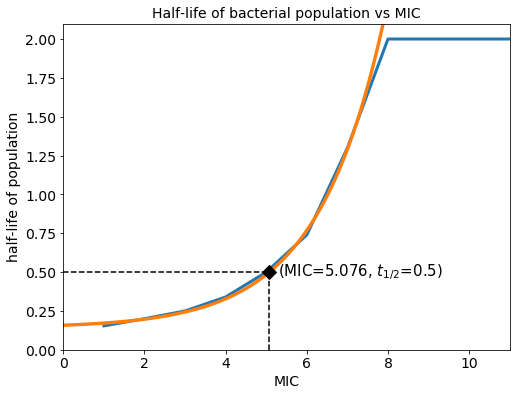

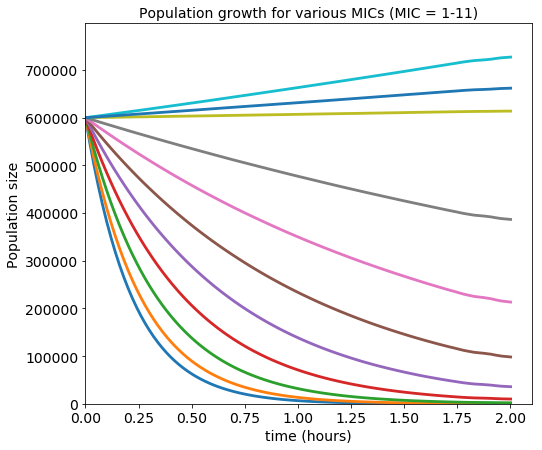

In [147]:
def extractMultipleMICCurves(filename):
    '''returns the list of MICs used, the times sampled over and the corresponding popualtion sizes'''
    
    #filename = 'Pyrithione_MICVarying_c=10.0.txt'
    
    with open(filename) as infile:
        
        reader = csv.reader(infile, delimiter="\t")
        file_headers = next(reader)
        #print(file_headers)
        nCols = len(file_headers) #gets the no. of columns in file, i.e., features of data

        column_array = [[] for i in range(nCols)] #creates an empty array of length nCols to store the data
        
        
        for row in reader:
            for i in range(len(row)):
                column_array[i].append(float(row[i].strip()))
                
        return file_headers[1:], column_array[0], column_array[1:]
    
    
def getHalfLifeOfMICCurve(timeData, input_curve):
    
    hl_index = -17
    
    for i in range(1, len(input_curve)):
        if input_curve[i] <= 0.5*input_curve[0]:
            hl_index = i
            break
        
    if hl_index > 0:
        return timeData[hl_index]
    else:
        return timeData[0]
    
def getAvgHalfLifeOfMICCurve(timeData, input_curve):
    
    hl_indexes = [0, 0]
    delta_t = [] # this stores all the half lifes measured in the curve
    # initialised with one value to prevent division by zero
    
    for i in range(1, len(input_curve)):
        if input_curve[i] <= 0.5*input_curve[hl_indexes[-1]]:
            hl_indexes.append(i)
            dt = timeData[hl_indexes[-1]] - timeData[hl_indexes[-2]]
            delta_t.append(dt)
            
    #hl_times = [timeData[i] for i in hl_indexes]
    if len(delta_t):
        return sum(delta_t)/len(delta_t)
    else:
        return max(timeData)
    
    

def plotMultipleMICCurves(filename):
    
    MIC_labels, times, MICpops = extractMultipleMICCurves(filename)
    
    plt.figure(figsize=(8,7))
    for mic in MICpops:
        plt.plot(times, mic, linewidth=2.8)
    
    plt.xlim(0,1.05*max(times))
    y_max = max(max(MICpops))
    plt.ylim(0, 1.3*y_max)
    
    font_size=14
    plt.tick_params(labelsize=14)
    plt.title('Population growth for various MICs (MIC = 1-11)', fontsize=font_size)
    plt.xlabel('time (hours)', fontsize=font_size)
    plt.ylabel('Population size', fontsize=font_size)
    plt.savefig('popSize(t)_vs_MIC.png')
    plt.show()
    
    
    
    
def plotHalfLifesOfMICs(filename):
    
    MIC_labels, times, MICpops = extractMultipleMICCurves(filename)
    half_life_lists = [getAvgHalfLifeOfMICCurve(times, mic) for mic in MICpops]
    relevant_hls = half_life_lists[:7] # the non-zero half lifes
    MIC_vals = [float(re.findall("\d+\.\d+", MIC_string)[0]) for MIC_string in MIC_labels]
    
    target_halfLife = 0.5 # the timeframe in hours desired for the population to decrease by half
    
    def fit_func(x, a, b, c):
        return b*np.exp(a*x) + c
    
    def objective(x, a, b, c):
        '''used to find the x-value of the above function given a y value'''
        return (0.5 - fit_func(x, a, b, c))**2
    
    
    mic_arr = np.array(MIC_vals[:7])
    hl_arr = np.array(relevant_hls)
    
    params = curve_fit(fit_func, mic_arr, hl_arr)
    [a, b, c] = params[0]
    
    # here we find the x value (MIC) for a given y-value (half-life)
    popt2, pcov2 = curve_fit(fit_func, mic_arr, hl_arr)
    res = minimize_scalar(objective, bracket=(1, 11), args=tuple(popt2))
    
    target_MIC = res.x # the half life required to obtain target_halfLife
    
    x_vals = np.linspace(0., 12, 400)
    fitted_hls = [fit_func(x, a, b, c) for x in x_vals]
    
    plt.figure(figsize=(8,6))
    plt.plot(MIC_vals, half_life_lists, linewidth=3) #recorded data
    plt.plot(x_vals, fitted_hls, linewidth=3.4) #fitted curve
    
    plt.plot(target_MIC, target_halfLife, marker='D', markersize=10, color='black') #plot desired MIC for specificied half-life
    plt.vlines(target_MIC, 0, target_halfLife, linestyle="dashed")
    plt.hlines(target_halfLife, 0, target_MIC, linestyle="dashed")
    targMIC_string = "{:.3f}".format(target_MIC)
    plt.text(target_MIC*1.04, target_halfLife *0.96, "(MIC="+targMIC_string+", $t_{1/2}$="+str(target_halfLife)+")", fontsize=15)
    
    font_size=14
    plt.title('Half-life of bacterial population vs MIC', fontsize=font_size)
    plt.xlabel('MIC', fontsize=font_size)
    plt.ylabel('half-life of population', fontsize=font_size)
    
    plt.tick_params(labelsize=14)
    plt.xlim(0,11.)
    plt.ylim(0,2.1)
    plt.savefig('halfLife_vs_MIC.png')
    plt.show()
    
    
    
    
    
plotHalfLifesOfMICs('Pyrithione_MICVarying_c=10.0.txt')
plotMultipleMICCurves('Pyrithione_MICVarying_c=10.0.txt')    
